# From beams to frames 

This notebooks introduce a simple method for frame modelling.
Objectives:
 - Solve the linear beam differential equations using sympy
 -
 

Import statements : we use sympy and matplotlib

In [1]:
from sympy import (Function, Symbol, Derivative, Eq, symbols, simplify, integrate, Matrix, Array, latex,
                   dsolve, sin, cos, collect, tensorcontraction,tensorproduct, derive_by_array)
import matplotlib.pyplot as plt

## Elemental beam problem

We start by solving the elemental beam problem. It consists of a clamped-clamped straight beam where we apply the displacement and rotations at the two ends. 
We denote by $\underline t$ and $\underline n$ the beam tangent and normal director, $L$ the beam length, $EI$ and $ES$ the bending and extensional stiffness. We assume an unsherable extensible Navier-Bernoulli model and that the beam. We decompose the displacement and rotation as follows:
$$
\underline{u}(s)=u(s)\underline t+v(s)\underline n,\qquad 
\underline{\theta}(s)=\theta(s)\,\underline b,\qquad\underline {b}:=\underline t\times\underline n
$$
We introduce below the notation and the expression of the potential energy using `sympy`

In [2]:
s, L = symbols("s L")
u, v = Function("u"), Function("v")
EI, EA = symbols("EI , ES")
bending_energy = EI/2 * integrate(v(s).diff(s,2)**2, (s,0,L))
extensional_energy = EA/2 * integrate(u(s).diff(s,1)**2, (s,0,L))
elastic_energy = bending_energy + extensional_energy
total_energy = elastic_energy # there are not external forces only applied displacements
total_energy

EI*Integral(Derivative(v(s), (s, 2))**2, (s, 0, L))/2 + ES*Integral(Derivative(u(s), s)**2, (s, 0, L))/2

In the absence of distributed loading the governing equations are as follows (they can by found by imposing the stationarity of the potential energy)
- Extension
$$
u''(s)=0\quad\forall  s\in(0,L),\qquad u(0)=u_0,\qquad u(L)=u_L
$$
- Bending 
$$
v''''(s)=0\quad\forall  s\in(0,L),\qquad v(0)=v_0,\;v'(0)=\theta_0,\; v(L)=v_L,\; v'(L)=\theta_L
$$

### Extension
We solve below the extensional problem using `sympy`

In [3]:
s, L = symbols("s L")
u0, uL = symbols("u_0 u_L")
eq = (Eq(Derivative(u(s),s,s),0))
usol = dsolve(eq,ics={u(0):u0,u(L):uL})
usol

Eq(u(s), u_0 + s*(-u_0 + u_L)/L)

### Bending
... and similarly for the bending problem

In [4]:
v0, vL, theta0, thetaL = symbols("v_0 v_L \\theta_0 \\theta_L")
eq = (Eq(v(s).diff(s,4),0))
vsol = dsolve(eq,ics={v(0): v0, 
               v(L): vL,
               v(s).diff(s).subs(s, 0): theta0,
               v(s).diff(s).subs(s, L): thetaL})
vsol

Eq(v(s), \theta_0*s + v_0 + s**2*(-2*L*\theta_0 - L*\theta_L - 3*v_0 + 3*v_L)/L**2 + s**3*(L*\theta_0 + L*\theta_L + 2*v_0 - 2*v_L)/L**3)

### Potential energy and elemental stiffness matrix
Hence, we can compute the potential energy of the system in terms of the imposed end-displacement and end-rotation in terms of an elemental stiffness matrix $\underline{\underline{K}}$ as 
$$
E_p(\underline U)=\dfrac{1}{2}(\underline{\underline K}.\underline{U}).\underline{U}
$$
where $\underline{U}$ is the vector collecting the imposed displacement and rotation

In [5]:
Ue = Array((u0,v0,theta0,uL,vL,thetaL))
Ue

[u_0, v_0, \theta_0, u_L, v_L, \theta_L]

The solution can be written in the form
$$
\begin{bmatrix}
u(s)\\v(s)
\end{bmatrix}
=\underline{\underline{D}}.\underline U_e
$$
where 


In [6]:
D = Matrix([[usol.rhs.diff(Ui) for Ui in Ue],
     [vsol.rhs.diff(Ui) for Ui in Ue]])
D

Matrix([
[1 - s/L,                             0,                        0, s/L,                         0,                   0],
[      0, 1 - 3*s**2/L**2 + 2*s**3/L**3, s - 2*s**2/L + s**3/L**2,   0, 3*s**2/L**2 - 2*s**3/L**3, -s**2/L + s**3/L**2]])

The total energy of the solution is

In [7]:
total_energy_sol = simplify(total_energy.subs({u(s):usol.rhs,v(s):vsol.rhs}))
total_energy_sol

(4*EI*(L**3*(3*L**2*\theta_0**2 + 6*L**2*\theta_0*\theta_L + 3*L**2*\theta_L**2 + 12*L*\theta_0*v_0 - 12*L*\theta_0*v_L + 12*L*\theta_L*v_0 - 12*L*\theta_L*v_L + 12*v_0**2 - 24*v_0*v_L + 12*v_L**2) + L**2*(-6*L**3*\theta_0**2 - 9*L**3*\theta_0*\theta_L - 3*L**3*\theta_L**2 - 21*L**2*\theta_0*v_0 + 21*L**2*\theta_0*v_L - 15*L**2*\theta_L*v_0 + 15*L**2*\theta_L*v_L - 18*L*v_0**2 + 36*L*v_0*v_L - 18*L*v_L**2) + L*(4*L**4*\theta_0**2 + 4*L**4*\theta_0*\theta_L + L**4*\theta_L**2 + 12*L**3*\theta_0*v_0 - 12*L**3*\theta_0*v_L + 6*L**3*\theta_L*v_0 - 6*L**3*\theta_L*v_L + 9*L**2*v_0**2 - 18*L**2*v_0*v_L + 9*L**2*v_L**2))/L**4 + ES*L*(-u_0 + u_L)**2)/(2*L**2)

And the elemental stiffness matrix is given by

In [8]:
Ke = Matrix([[total_energy_sol.diff(Ui,Uj) for Ui in Ue] for Uj in Ue])
Ke

Matrix([
[ ES/L,           0,          0, -ES/L,           0,          0],
[    0,  12*EI/L**3,  6*EI/L**2,     0, -12*EI/L**3,  6*EI/L**2],
[    0,   6*EI/L**2,     4*EI/L,     0,  -6*EI/L**2,     2*EI/L],
[-ES/L,           0,          0,  ES/L,           0,          0],
[    0, -12*EI/L**3, -6*EI/L**2,     0,  12*EI/L**3, -6*EI/L**2],
[    0,   6*EI/L**2,     2*EI/L,     0,  -6*EI/L**2,     4*EI/L]])

## Global frame and change of coordinate

Let us known introduce a global frame $(0,\underline{e_1},\underline{e_2})$ and let us call $\alpha$ the angle giving the orientation of the tangent  and normal vector in this frame. We can then define the coordinates of the displacement vector $\underline u$ in this new frame

In [9]:
alpha = Symbol("\\alpha")
t = Array([cos(alpha), sin(alpha)])
n = Array([-sin(alpha), cos(alpha)])
u_star = u(s) * t + v(s) * n
u_star

[u(s)*cos(\alpha) - v(s)*sin(\alpha), u(s)*sin(\alpha) + v(s)*cos(\alpha)]

We define $\underline{U}^*_{e}$ the vector giving the component of the end-displacement 
 $\underline{U}_e$ in the global frame. 
Hence, we compute the following orthogonal matrix $T$ such that 
$$\underline{U}^*_e = T.\underline{U}_e,\qquad
\underline{U}_e = T^t.\underline{U}^*_e$$

In [10]:
u0_s = u0 * t + v0 * n
uL_s = uL * t + vL * n
Ue_s = Array((u0_s[0],u0_s[1],theta0,uL_s[0],uL_s[1],thetaL))
T = Matrix([Ue_s.diff(Ui) for Ui in Ue])
T


Matrix([
[ cos(\alpha), sin(\alpha), 0,            0,           0, 0],
[-sin(\alpha), cos(\alpha), 0,            0,           0, 0],
[           0,           0, 1,            0,           0, 0],
[           0,           0, 0,  cos(\alpha), sin(\alpha), 0],
[           0,           0, 0, -sin(\alpha), cos(\alpha), 0],
[           0,           0, 0,            0,           0, 1]])

The local stiffness matrix in the new coordinate is defined by


In [11]:
Ke_s = (T*Ke)*T.transpose()
Ke_s

Matrix([
[                   12*EI*sin(\alpha)**2/L**3 + ES*cos(\alpha)**2/L,  12*EI*sin(\alpha)*cos(\alpha)/L**3 - ES*sin(\alpha)*cos(\alpha)/L,  6*EI*sin(\alpha)/L**2,                   -12*EI*sin(\alpha)**2/L**3 - ES*cos(\alpha)**2/L, -12*EI*sin(\alpha)*cos(\alpha)/L**3 + ES*sin(\alpha)*cos(\alpha)/L,  6*EI*sin(\alpha)/L**2],
[ 12*EI*sin(\alpha)*cos(\alpha)/L**3 - ES*sin(\alpha)*cos(\alpha)/L,                    12*EI*cos(\alpha)**2/L**3 + ES*sin(\alpha)**2/L,  6*EI*cos(\alpha)/L**2, -12*EI*sin(\alpha)*cos(\alpha)/L**3 + ES*sin(\alpha)*cos(\alpha)/L,                   -12*EI*cos(\alpha)**2/L**3 - ES*sin(\alpha)**2/L,  6*EI*cos(\alpha)/L**2],
[                                             6*EI*sin(\alpha)/L**2,                                              6*EI*cos(\alpha)/L**2,                 4*EI/L,                                             -6*EI*sin(\alpha)/L**2,                                             -6*EI*cos(\alpha)/L**2,                 2*EI/L],
[                  -12*EI

## Frame: assembling several beams

### Define nodes and geometry

In [12]:
import numpy as np

nodes = np.array([[0,0],
         [1,1],
         [2,0]])

elements = np.array([[0,1],
                         [1,2]])

n_nodes = len(nodes)
n_elements = len(elements)

def dof_map(e,i):
    """Returns the global dof number giving element and local dof number"""
    return 3 * e + i

def length(element_nodes):
    """Returns the element length"""
    vec = element_nodes[1]-element_nodes[0]
    return np.sqrt(np.dot(vec,vec))
    
def angle(element_nodes):
    """Returns the element orientation"""
    vec = element_nodes[1]-element_nodes[0]
    return np.arctan2(vec[1],vec[0])

Ls = np.array([length(nodes[el]) for el in elements])
alphas = np.array([angle(nodes[el]) for el in elements])
print(alphas)
print(Ls)


[ 0.78539816 -0.78539816]
[1.41421356 1.41421356]


### Introduce global vector and mapping to local vectors

In [13]:
U = np.ones(3 * n_nodes)

def U_elem(U,e):
    """ Returns the element local values in global coordinates"""
    return np.array([U[dof_map(e,i)] for i in range(6)])

def U_elem_loc(U,e):
    """ Returns the element local values in local coordinates"""
    T_mat = T.transpose().subs({alpha:alphas[e]})
    return  np.dot(T_mat, U_elem(U,e))

def U_node(U,n):
    """ Returns the displacement of a node"""
    return U.take([3 * n ,3 * n + 1])



### Assembling the stiffness matrix

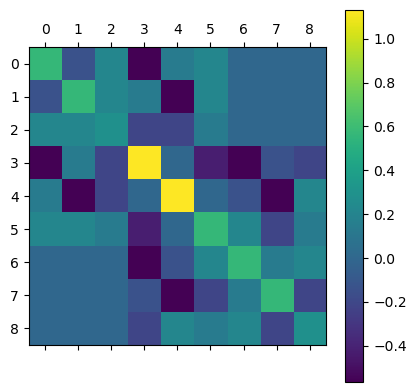

In [14]:
EA_n = 1.
EI_n = 0.1
EAs = np.ones(len(elements))
EIs = EI_n* np.ones(len(elements))
K_global = np.zeros([3 * n_nodes,3 * n_nodes])
for e, element in enumerate(elements):
    K_element = np.array(Ke_s.subs({"L" : Ls[e], 
                                    "ES" : EAs[e],
                                    "EI" : EIs[e],
                                    "\\alpha" : alphas[e]
                                    }),dtype=float)
    global_dofs = [3 * element[0], 3 * element[0]+1, 3 * element[0] + 2, 3 *  element[1], 3 *  element[1]+1, 3 *  element[1] + 2] 
    K_global[np.ix_(global_dofs,global_dofs)] += K_element #[i:i+3,i:i+3]
    
plt.matshow(K_global,interpolation='none')
plt.colorbar()

In [15]:
Matrix(K_global)

Matrix([
[ 0.565685424949238,  -0.14142135623731,  0.212132034355964, -0.565685424949238,   0.14142135623731,  0.212132034355964,                  0,                  0,                  0],
[ -0.14142135623731,  0.565685424949238,  0.212132034355964,   0.14142135623731, -0.565685424949238,  0.212132034355964,                  0,                  0,                  0],
[ 0.212132034355964,  0.212132034355964,  0.282842712474619, -0.212132034355964, -0.212132034355964,   0.14142135623731,                  0,                  0,                  0],
[-0.565685424949238,   0.14142135623731, -0.212132034355964,   1.13137084989848,                  0, -0.424264068711928, -0.565685424949238,  -0.14142135623731, -0.212132034355964],
[  0.14142135623731, -0.565685424949238, -0.212132034355964,                  0,   1.13137084989848,                  0,  -0.14142135623731, -0.565685424949238,  0.212132034355964],
[ 0.212132034355964,  0.212132034355964,   0.14142135623731, -0.424264068711928, 

### Apply BCs and loads
To apply the boundary condition we modify the linear system to solve (see the finite element class)

In [16]:
def bc_apply(K,F,blocked_dof,bc_values):
    for (i, dof) in enumerate(blocked_dof): 
        Kbc = K 
        Fbc = F
        Kbc[dof, :] = 0
        Kbc[:, dof] = 0
        Kbc[dof, dof] = 1
        Fbc +=  - K[:,dof]*bc_values[i]
        Fbc[dof] = bc_values[i]
    return Kbc, Fbc

We select the blocked dofs, the apply force and define the final linear system to solve

In [17]:
blocked_dof= np.array([0,1,6,7])
bc_values = np.zeros_like(blocked_dof)
print(blocked_dof)
U = np.zeros(n_nodes *3)
F = np.zeros(n_nodes *3)
F[3 * 1] = 1
F[3 * 1 + 1] = 1
Kbc, Fbc = bc_apply(K_global, F, blocked_dof, bc_values)
Matrix(Kbc), Matrix(Fbc)

[0 1 6 7]


(Matrix([
 [1.0,   0,                  0,                  0,                  0,                  0,   0,   0,                  0],
 [  0, 1.0,                  0,                  0,                  0,                  0,   0,   0,                  0],
 [  0,   0,  0.282842712474619, -0.212132034355964, -0.212132034355964,   0.14142135623731,   0,   0,                  0],
 [  0,   0, -0.212132034355964,   1.13137084989848,                  0, -0.424264068711928,   0,   0, -0.212132034355964],
 [  0,   0, -0.212132034355964,                  0,   1.13137084989848,                  0,   0,   0,  0.212132034355964],
 [  0,   0,   0.14142135623731, -0.424264068711928,                  0,  0.565685424949238,   0,   0,   0.14142135623731],
 [  0,   0,                  0,                  0,                  0,                  0, 1.0,   0,                  0],
 [  0,   0,                  0,                  0,                  0,                  0,   0, 1.0,                  0],
 [  0,

### Solve the linear system

In [18]:
Usol = np.linalg.solve(Kbc,Fbc)
Usol

array([ 0.        ,  0.        ,  1.62941997,  1.41421356,  1.22975092,
        0.70710678,  0.        ,  0.        , -0.21520641])

### Visualize the results

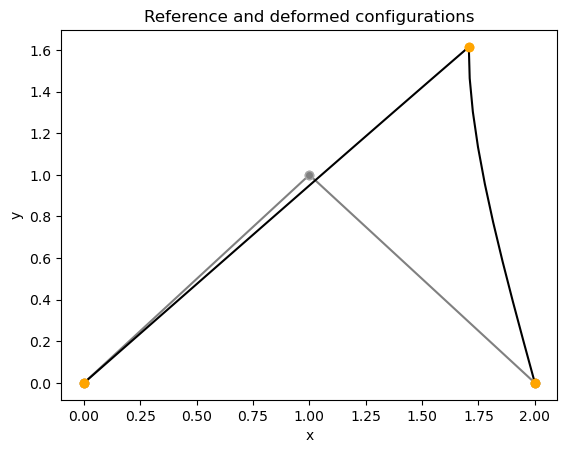

In [19]:
def element_displacement(U_s,e):
    return np.dot((Matrix([t, n]) * D).subs({alpha:alphas[e],L:Ls[e]}), U_elem_loc(U_s,e))

def element_initial(e):
    return nodes[elements[e][0]] + s * t.subs({alpha:alphas[e]})

def element_deformed(U_s,e,factor=1.0):
    return element_initial(e) + factor * element_displacement(U_s,e)


ss = np.linspace(0,1,10)
for e, el in enumerate(elements):
    fun = element_initial(e)
    plt.plot([fun[0].subs({s:sv}) for sv in ss * Ls[e]], [fun[1].subs({s:sv}) for sv in ss * Ls[e]],"gray")
    plt.plot(*nodes.T,'o',markerfacecolor="gray",markeredgecolor="darkgray")
    
for e, el in enumerate(elements):
    factor = .5 
    fun = element_deformed(Usol,e,factor=factor)
    plt.plot([fun[0].subs({s:sv}) for sv in ss * Ls[e]], [fun[1].subs({s:sv}) for sv in ss * Ls[e]],"black")
    plt.plot(*np.array([nodes[n] + factor * U_node(Usol,n) for n in range(len(nodes))]).T,
             'o',markerfacecolor="orange",markeredgecolor="orange")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Reference and deformed configurations")
    

### Verification

The exact solution for the nodal displacement of the top node is (see Ballard, page 74)

In [20]:
u_exact = simplify(Array([L/EA ,(1- 1/(1 + (EA * L**2)/(3 * EI)) ) * (L/EA)]))
print(u_exact.subs({L:Ls[1],EA:EA_n,EI:EI_n}))


[1.4142135623731, 1.22975092380269]


The numerical solution is

In [21]:
U_node(Usol,1)

array([1.41421356, 1.22975092])

## Exercice 

1. Build you own frame structure with the Mola model. 
2. Define the corresponding frame model by modifying this notebook
3. Choose a load case and perform a qualitative comparison of the structural deformed configuration:
    - Take a photo of the deformed configuration of the real structure under the imposed load
    - Compare qualitatively with the deformed configuration plot obtained with your code